# PredARGs

## Dataset

In [1]:
import numpy as np
import re
import csv
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from transformers import AutoTokenizer, AutoModel
import torch


def load_aro_index(file_path):
    """
    Loads the TSV file and returns a dictionary mapping the ARO number
    to its corresponding Drug Class.
    """
    aro_mapping = {}
    with open(file_path, 'r') as tsvfile:
        reader = csv.DictReader(tsvfile, delimiter='\t')
        for row in reader:
            aro_id = row["ARO Accession"]
            drug_class = row["Drug Class"]
            aro_mapping[aro_id] = drug_class
    return aro_mapping

def extract_aro_number(record_id):
    """
    Extracts and returns the ARO number from the record ID string.
    """
    match = re.search(r'(ARO:\d+)', record_id)
    if match:
        return match.group(1)
    return None

def extract_species(description):
    """
    Extracts the species from the description.
    The species is expected to be enclosed in square brackets.
    """
    match = re.search(r'\[([^]]+)\]', description)
    if match:
        return match.group(1).strip()
    return None

# Load the ARO to Drug Class mapping from the TSV file
aro_index_file = "card-data/aro_index.tsv"
aro_mapping = load_aro_index(aro_index_file)

# FASTA file path
fasta_file = "card-data/nucleotide_fasta_protein_homolog_model.fasta"

# List to store the records as dictionaries
records_list = []

# Iterate over each record in the FASTA file
for record in SeqIO.parse(fasta_file, "fasta"):
    # Extract the ARO number from the record ID
    aro_number = extract_aro_number(record.id)
    # Retrieve the corresponding Drug Class as a string.
    # If not found, default to "Not Found".
    if aro_number:
        drug_class_str = aro_mapping.get(aro_number, "Not Found")
        # Convert the drug class string to a list by splitting on ';' and stripping whitespace.
        drug_class_list = [d.strip() for d in drug_class_str.split(';')]
    else:
        drug_class_list = []
    
    # Extract species from the description using text between square brackets
    species = extract_species(record.description)
    

    record_dict = {
        "id": record.id.split('|')[1] if '|' in record.id else record.id,
        "description": record.description,
        "sequence": str(record.seq),
        "length": len(record.seq),
        "aro_number": aro_number,
        "drug_class": drug_class_list,
        "species": species
    }
    records_list.append(record_dict)

df = pd.DataFrame(records_list)
df


,id,description,sequence,length,aro_number,drug_class,species
0,GQ343019.1,gb|GQ343019.1|+|132-1023|ARO:3002999|CblA-1 [m...,ATGAAAGCATATTTCATCGCCATACTTACCTTATTCACTTGTATAG...,891,ARO:3002999,[cephalosporin],mixed culture bacterium AX_gF3SD01_15
1,HQ845196.1,gb|HQ845196.1|+|0-861|ARO:3001109|SHV-52 [Kleb...,ATGCGTTATATTCGCCTGTGTATTATCTCCCTGTTAGCCGCCCTGC...,861,ARO:3001109,"[cephalosporin, penicillin beta-lactam]",Klebsiella pneumoniae
2,AF028812.1,gb|AF028812.1|+|392-887|ARO:3002867|dfrF [Ente...,ATGATAGGTTTGATTGTTGCGAGGTCAAAGAATAATGTTATAGGCA...,495,ARO:3002867,[diaminopyrimidine antibiotic],Enterococcus faecalis
3,JX017365.1,gb|JX017365.1|+|244-1120|ARO:3001989|CTX-M-130...,ATGGTGACAAAGAGAGTGCAACGGATGATGTTCGCGGCGGCGGCGT...,876,ARO:3001989,[cephalosporin],Escherichia coli
4,JN967644.1,gb|JN967644.1|+|0-813|ARO:3002356|NDM-6 [Esche...,ATGGAATTGCCCAATATTATGCACCCGGTCGCGAAGCTGAGCACCG...,813,ARO:3002356,"[carbapenem, cephalosporin, penicillin beta-la...",Escherichia coli
...,...,...,...,...,...,...,...
6043,AF321608.1,gb|AF321608.1|+|0-888|ARO:3003561|SED-1 [Citro...,ATGCTTAAGGAACGGTTTCGCCAGACGGTATTTATCGCTGCCGCTG...,888,ARO:3003561,"[cephalosporin, penicillin beta-lactam]",Citrobacter sedlakii
6044,JADDIJ010000014.1,gb|JADDIJ010000014.1|+|17-767|ARO:3009098|CfiA...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009098,[carbapenem],Bacteroides fragilis
6045,OL739393.1,gb|OL739393.1|+|0-750|ARO:3009099|CfiA29 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009099,[carbapenem],Bacteroides fragilis
6046,OQ379238.1,gb|OQ379238.1|+|0-750|ARO:3009100|CfiA30 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009100,[carbapenem],Bacteroides fragilis


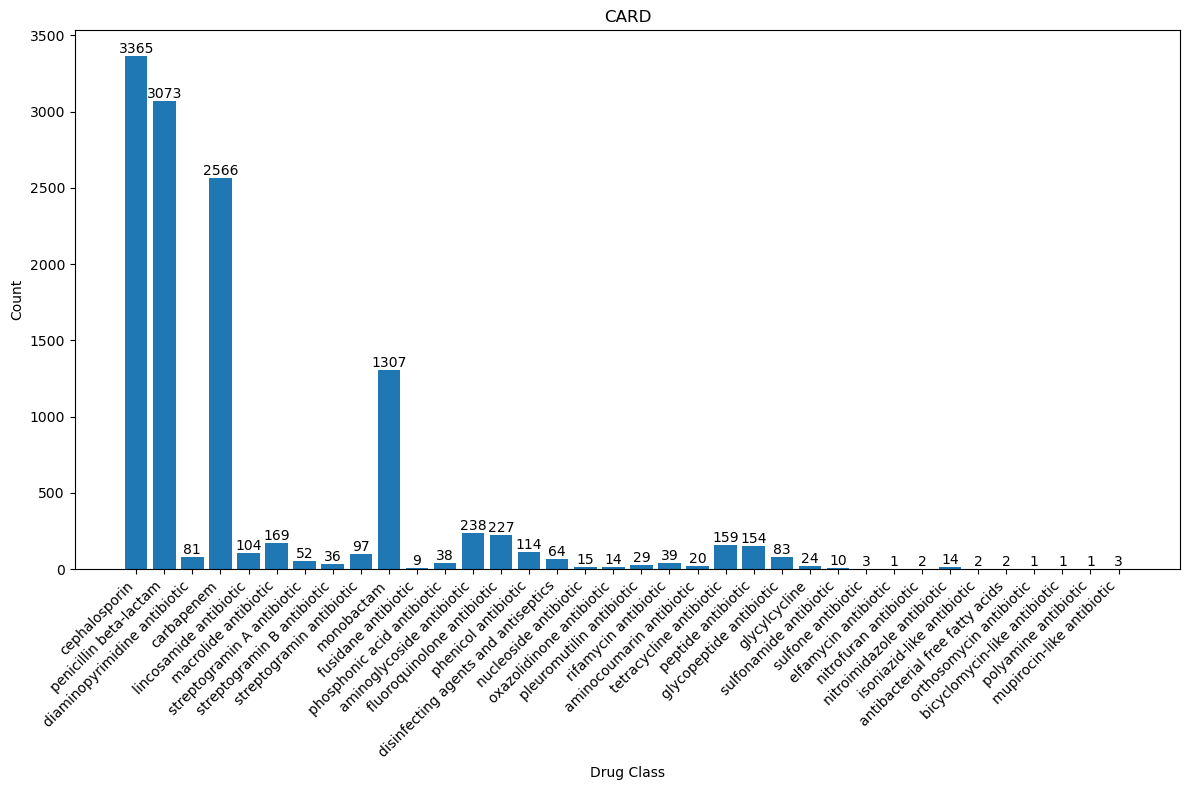

In [2]:
from collections import Counter

drug_class_lists = df["drug_class"].tolist()

# Flatten the list of lists into a single list of drug classes
flattened_drug_classes = [drug for sublist in drug_class_lists for drug in sublist]

drug_class_counts = Counter(flattened_drug_classes)

all_drug_classes = list(drug_class_counts.keys())
counts = list(drug_class_counts.values())

plt.figure(figsize=(12, 8))
bars = plt.bar(all_drug_classes, counts)
plt.xlabel("Drug Class")
plt.ylabel("Count")
plt.title("CARD")
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [3]:
selected_drug_classes = [drug_class for drug_class, count in drug_class_counts.items() if count >= 2000]

print("Selected drug classes:")

drug_class_tokenizer = {drug: token for token, drug in enumerate(selected_drug_classes, start=1)}
print(drug_class_tokenizer)
print('Total:', len(drug_class_tokenizer))

Selected drug classes:
{'cephalosporin': 1, 'penicillin beta-lactam': 2, 'carbapenem': 3}
Total: 3


In [4]:
def has_selected_drug_class(drug_class_list):
    """
    Returns True if any drug class in the list is in selected_drug_classes.
    """
    for drug_class in drug_class_list:
        if drug_class in selected_drug_classes:
            return True
    return False

mask = df['drug_class'].apply(has_selected_drug_class)
df1 = df[mask].copy()


def has_no_selected_drug_class(drug_class_list):
    return all(drug_class not in selected_drug_classes for drug_class in drug_class_list)

df0 = df[df['drug_class'].apply(has_no_selected_drug_class)]

n_classes = len(selected_drug_classes)

print(f"Positive samples: {len(df1)}")
print(f"Negative samples: {len(df0)}")



Positive samples: 4967
Negative samples: 1081


In [5]:
# Save the DataFrame as a FASTA
with open("data/args.fasta", "w") as fasta_file:
    for index, row in df1.iterrows():
        fasta_file.write(">" + row["description"] + "\n")
        fasta_file.write(row["sequence"] + "\n")


In [6]:
n_classes = len(selected_drug_classes)

sequences = df["sequence"].tolist()
drug_classes = df["drug_class"].tolist()

drug_classes_filtered = [
    [drug for drug in drug_list if drug in selected_drug_classes] for drug_list in drug_classes
]

# Transform each list of drug classes in drug_classes_filtered into tokens
drug_classes_tokens = [
    [drug_class_tokenizer[drug] for drug in drug_list] 
    for drug_list in drug_classes_filtered
]

print("Drug classes as tokens:")
print(drug_classes_tokens)

# Create a binary vector for each sample
output_vectors = []
for tokens in drug_classes_tokens:
    vector = np.zeros(n_classes, dtype=int)
    # For each token in the sample's token list, mark the corresponding index as 1.
    # Since the tokens are indexed starting at 1, subtract 1 to get the correct index.
    for token in tokens:
        vector[token - 1] = 1
    output_vectors.append(vector)

output_array = np.array(output_vectors)

print("Shape of output array:", output_array.shape)
print("Output array:")
print(output_array)


Drug classes as tokens:
[[1], [1, 2], [], [1], [3, 1, 2], [3, 1, 2], [2], [], [1, 2], [1, 2], [1, 2], [1, 2], [3, 1, 2], [3, 2], [3, 1, 2], [1], [3, 2], [3, 1, 2], [3, 2], [], [1], [1], [], [2], [1, 2], [1], [1], [], [1, 2], [], [], [], [], [], [1, 2], [3, 1, 2], [], [1], [3, 2], [3, 2], [3], [], [1, 2], [1, 2], [1, 2], [3, 2], [1, 2], [1, 2], [], [1, 2], [], [3, 2], [1], [], [1], [3, 1, 2], [1, 2], [3, 2], [1, 2], [], [3, 1, 2], [], [1, 2], [1, 2], [1, 2], [], [1, 2], [1, 2], [1, 2], [3, 1, 2], [3, 1, 2], [1], [3, 1, 2], [3, 1, 2], [3, 1, 2], [1, 2], [1, 2], [1], [2], [1], [1, 2], [1], [1], [3, 2], [1], [], [1, 2], [1], [1, 2], [2], [2], [], [1, 2], [3, 1], [], [], [1], [], [1, 2], [], [1, 2], [3, 1, 2], [], [2], [3, 1, 2], [1, 2], [3], [1, 2], [1, 2], [], [], [], [1], [1], [1, 2], [], [], [3], [1], [], [], [], [3], [3, 1, 2], [3, 2], [3, 2], [3, 2], [1, 2], [], [], [1, 2], [], [], [1, 2], [1, 2], [], [], [], [], [3, 2], [1, 2], [3, 1, 2], [3, 2], [], [3, 1, 2], [], [], [], [], [1], [

In [7]:
df = df.copy()
df['drug_class_tokens'] = drug_classes_tokens
df['output_vector'] = list(output_array)

df


,id,description,sequence,length,aro_number,drug_class,species,drug_class_tokens,output_vector
0,GQ343019.1,gb|GQ343019.1|+|132-1023|ARO:3002999|CblA-1 [m...,ATGAAAGCATATTTCATCGCCATACTTACCTTATTCACTTGTATAG...,891,ARO:3002999,[cephalosporin],mixed culture bacterium AX_gF3SD01_15,[1],"[1, 0, 0]"
1,HQ845196.1,gb|HQ845196.1|+|0-861|ARO:3001109|SHV-52 [Kleb...,ATGCGTTATATTCGCCTGTGTATTATCTCCCTGTTAGCCGCCCTGC...,861,ARO:3001109,"[cephalosporin, penicillin beta-lactam]",Klebsiella pneumoniae,"[1, 2]","[1, 1, 0]"
2,AF028812.1,gb|AF028812.1|+|392-887|ARO:3002867|dfrF [Ente...,ATGATAGGTTTGATTGTTGCGAGGTCAAAGAATAATGTTATAGGCA...,495,ARO:3002867,[diaminopyrimidine antibiotic],Enterococcus faecalis,[],"[0, 0, 0]"
3,JX017365.1,gb|JX017365.1|+|244-1120|ARO:3001989|CTX-M-130...,ATGGTGACAAAGAGAGTGCAACGGATGATGTTCGCGGCGGCGGCGT...,876,ARO:3001989,[cephalosporin],Escherichia coli,[1],"[1, 0, 0]"
4,JN967644.1,gb|JN967644.1|+|0-813|ARO:3002356|NDM-6 [Esche...,ATGGAATTGCCCAATATTATGCACCCGGTCGCGAAGCTGAGCACCG...,813,ARO:3002356,"[carbapenem, cephalosporin, penicillin beta-la...",Escherichia coli,"[3, 1, 2]","[1, 1, 1]"
...,...,...,...,...,...,...,...,...,...
6043,AF321608.1,gb|AF321608.1|+|0-888|ARO:3003561|SED-1 [Citro...,ATGCTTAAGGAACGGTTTCGCCAGACGGTATTTATCGCTGCCGCTG...,888,ARO:3003561,"[cephalosporin, penicillin beta-lactam]",Citrobacter sedlakii,"[1, 2]","[1, 1, 0]"
6044,JADDIJ010000014.1,gb|JADDIJ010000014.1|+|17-767|ARO:3009098|CfiA...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009098,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]"
6045,OL739393.1,gb|OL739393.1|+|0-750|ARO:3009099|CfiA29 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009099,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]"
6046,OQ379238.1,gb|OQ379238.1|+|0-750|ARO:3009100|CfiA30 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009100,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]"


## MMSeqs2

In [8]:
# ! mmseqs easy-cluster data/args.fasta mmseqs2/clusterRes tmp --min-seq-id 0.7 -c 0.7 --cov-mode 1


In [9]:
df_cluster = pd.read_csv("mmseqs2/clusterRes_cluster.tsv", sep="\t", header=None, names=["cluster_representative", "member"])

# Create a mapping from member ID to cluster representative.
cluster_map = df_cluster.set_index("member")["cluster_representative"].to_dict()

# Map the cluster representative to each row in df (based on 'id').
df["cluster_representative"] = df["id"].map(cluster_map)

# Compute the total occurrences (i.e. cluster size) for each cluster representative.
rep_counts = df_cluster["cluster_representative"].value_counts()

# Create a new column "cluster_size" that maps the representative to its occurrence count.
df["cluster_size"] = df["cluster_representative"].map(rep_counts).fillna(0).astype(int)

df

,id,description,sequence,length,aro_number,drug_class,species,drug_class_tokens,output_vector,cluster_representative,cluster_size
0,GQ343019.1,gb|GQ343019.1|+|132-1023|ARO:3002999|CblA-1 [m...,ATGAAAGCATATTTCATCGCCATACTTACCTTATTCACTTGTATAG...,891,ARO:3002999,[cephalosporin],mixed culture bacterium AX_gF3SD01_15,[1],"[1, 0, 0]",GQ343019.1,1
1,HQ845196.1,gb|HQ845196.1|+|0-861|ARO:3001109|SHV-52 [Kleb...,ATGCGTTATATTCGCCTGTGTATTATCTCCCTGTTAGCCGCCCTGC...,861,ARO:3001109,"[cephalosporin, penicillin beta-lactam]",Klebsiella pneumoniae,"[1, 2]","[1, 1, 0]",AM941846.1,324
2,AF028812.1,gb|AF028812.1|+|392-887|ARO:3002867|dfrF [Ente...,ATGATAGGTTTGATTGTTGCGAGGTCAAAGAATAATGTTATAGGCA...,495,ARO:3002867,[diaminopyrimidine antibiotic],Enterococcus faecalis,[],"[0, 0, 0]",NaN,0
3,JX017365.1,gb|JX017365.1|+|244-1120|ARO:3001989|CTX-M-130...,ATGGTGACAAAGAGAGTGCAACGGATGATGTTCGCGGCGGCGGCGT...,876,ARO:3001989,[cephalosporin],Escherichia coli,[1],"[1, 0, 0]",AB916359.1,90
4,JN967644.1,gb|JN967644.1|+|0-813|ARO:3002356|NDM-6 [Esche...,ATGGAATTGCCCAATATTATGCACCCGGTCGCGAAGCTGAGCACCG...,813,ARO:3002356,"[carbapenem, cephalosporin, penicillin beta-la...",Escherichia coli,"[3, 1, 2]","[1, 1, 1]",KY503030.1,76
...,...,...,...,...,...,...,...,...,...,...,...
6043,AF321608.1,gb|AF321608.1|+|0-888|ARO:3003561|SED-1 [Citro...,ATGCTTAAGGAACGGTTTCGCCAGACGGTATTTATCGCTGCCGCTG...,888,ARO:3003561,"[cephalosporin, penicillin beta-lactam]",Citrobacter sedlakii,"[1, 2]","[1, 1, 0]",AF321608.1,2
6044,JADDIJ010000014.1,gb|JADDIJ010000014.1|+|17-767|ARO:3009098|CfiA...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009098,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]",M63556.1,21
6045,OL739393.1,gb|OL739393.1|+|0-750|ARO:3009099|CfiA29 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009099,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]",M63556.1,21
6046,OQ379238.1,gb|OQ379238.1|+|0-750|ARO:3009100|CfiA30 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009100,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]",M63556.1,21


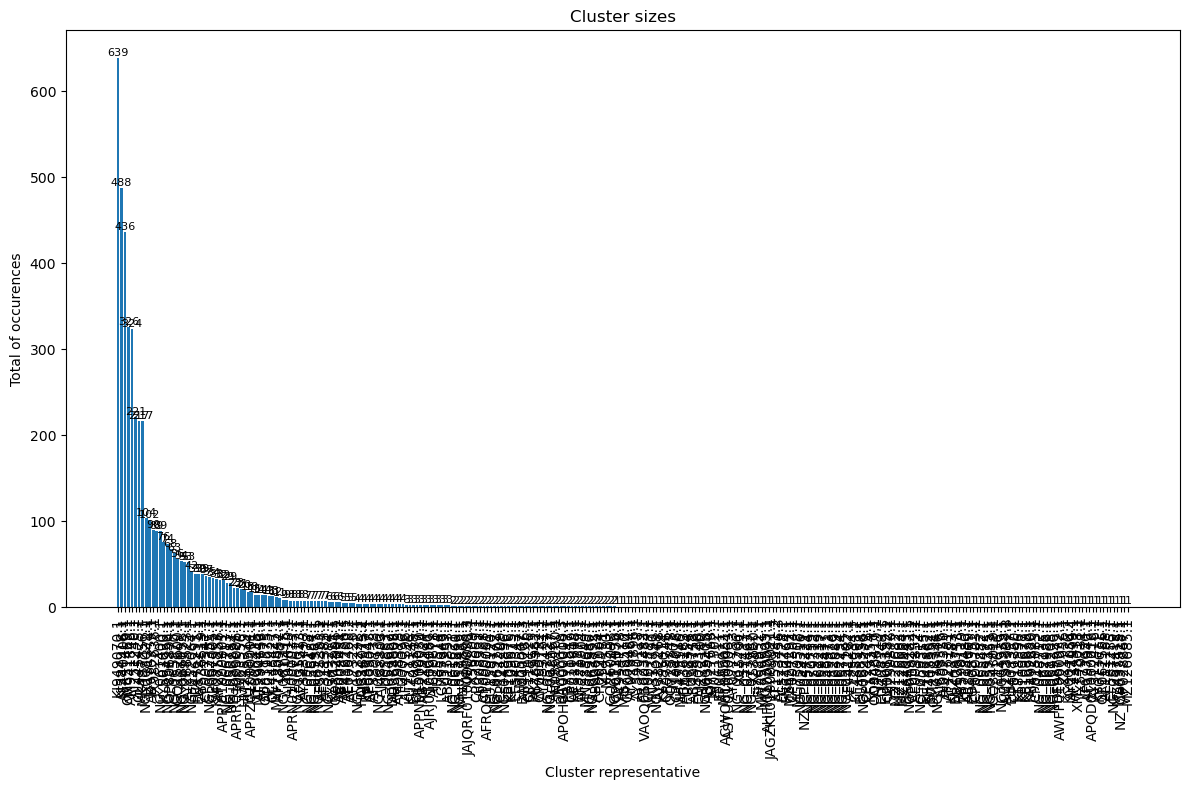

In [10]:
rep_series = rep_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.bar(rep_series.index.astype(str), rep_series.values)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.2, str(height),
             ha='center', va='bottom', fontsize=8)
plt.xlabel("Cluster representative")
plt.ylabel("Total of occurences")
plt.title("Cluster sizes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### DNABERT-2

In [11]:
# Load pretrained model DNABERT-2-117M
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
dnabert_model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# List to store the embeddings for each sequence
embeddings = []

# Process each sequence
sequences = df["sequence"].tolist()

for dna in sequences:
    # Tokenize the sequence and obtain input_ids as a tensor
    inputs = tokenizer(dna, return_tensors='pt')["input_ids"]
    
    # Disable gradient computation for inference
    with torch.no_grad():
        hidden_states = dnabert_model(inputs)[0]  # hidden_states shape: [1, sequence_length, 768]
    
    # Compute the embedding using mean pooling along the token dimension
    embedding_mean = torch.mean(hidden_states[0], dim=0)

    # # Embedding with max pooling
    # embedding_max = torch.max(hidden_states[0], dim=0)
    
    # Append the embedding (converted to a NumPy array) to the list
    embeddings.append(embedding_mean.numpy())

# Optionally, convert the list of embeddings into a NumPy array for further analysis
embeddings = np.array(embeddings)
print("Shape of embeddings:", embeddings.shape)

np.save('data/embeddings_01.npy', embeddings)


/home/shoji/miniconda3/envs/argsvenv/lib/python3.8/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/shoji/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are i

Shape of embeddings: (6048, 768)


In [12]:
embeddings = np.load('data/embeddings_01.npy')
df['embeddings'] = list(embeddings)
df.to_csv("data/df01.csv", index=True)

df


,id,description,sequence,length,aro_number,drug_class,species,drug_class_tokens,output_vector,cluster_representative,cluster_size,embeddings
0,GQ343019.1,gb|GQ343019.1|+|132-1023|ARO:3002999|CblA-1 [m...,ATGAAAGCATATTTCATCGCCATACTTACCTTATTCACTTGTATAG...,891,ARO:3002999,[cephalosporin],mixed culture bacterium AX_gF3SD01_15,[1],"[1, 0, 0]",GQ343019.1,1,"[-0.034027234, 0.1348137, 0.07259814, -0.10387..."
1,HQ845196.1,gb|HQ845196.1|+|0-861|ARO:3001109|SHV-52 [Kleb...,ATGCGTTATATTCGCCTGTGTATTATCTCCCTGTTAGCCGCCCTGC...,861,ARO:3001109,"[cephalosporin, penicillin beta-lactam]",Klebsiella pneumoniae,"[1, 2]","[1, 1, 0]",AM941846.1,324,"[-0.009320669, 0.10276397, 0.124337204, -0.102..."
2,AF028812.1,gb|AF028812.1|+|392-887|ARO:3002867|dfrF [Ente...,ATGATAGGTTTGATTGTTGCGAGGTCAAAGAATAATGTTATAGGCA...,495,ARO:3002867,[diaminopyrimidine antibiotic],Enterococcus faecalis,[],"[0, 0, 0]",NaN,0,"[-0.050583053, 0.11240079, 0.046022065, -0.049..."
3,JX017365.1,gb|JX017365.1|+|244-1120|ARO:3001989|CTX-M-130...,ATGGTGACAAAGAGAGTGCAACGGATGATGTTCGCGGCGGCGGCGT...,876,ARO:3001989,[cephalosporin],Escherichia coli,[1],"[1, 0, 0]",AB916359.1,90,"[-0.032540582, 0.13854147, 0.121218815, -0.121..."
4,JN967644.1,gb|JN967644.1|+|0-813|ARO:3002356|NDM-6 [Esche...,ATGGAATTGCCCAATATTATGCACCCGGTCGCGAAGCTGAGCACCG...,813,ARO:3002356,"[carbapenem, cephalosporin, penicillin beta-la...",Escherichia coli,"[3, 1, 2]","[1, 1, 1]",KY503030.1,76,"[0.0007669624, 0.1779555, 0.0966649, -0.098779..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6043,AF321608.1,gb|AF321608.1|+|0-888|ARO:3003561|SED-1 [Citro...,ATGCTTAAGGAACGGTTTCGCCAGACGGTATTTATCGCTGCCGCTG...,888,ARO:3003561,"[cephalosporin, penicillin beta-lactam]",Citrobacter sedlakii,"[1, 2]","[1, 1, 0]",AF321608.1,2,"[-0.042109065, 0.13090503, 0.15164734, -0.0928..."
6044,JADDIJ010000014.1,gb|JADDIJ010000014.1|+|17-767|ARO:3009098|CfiA...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009098,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]",M63556.1,21,"[-0.029507617, 0.15983415, 0.111860216, -0.135..."
6045,OL739393.1,gb|OL739393.1|+|0-750|ARO:3009099|CfiA29 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009099,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]",M63556.1,21,"[-0.03001005, 0.15579607, 0.12520112, -0.13532..."
6046,OQ379238.1,gb|OQ379238.1|+|0-750|ARO:3009100|CfiA30 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009100,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]",M63556.1,21,"[-0.023755297, 0.15712255, 0.12169745, -0.1371..."


In [13]:
from sklearn.model_selection import train_test_split
random_state = 42

def choose_label(vector):    
    """
    Randomly selects a label from the vector where the value is 1.
    If the vector contains only zeros, it returns 0 (negative class).
    """
    # Find all indices where the value is 1
    indices = [i+1 for i, value in enumerate(vector) if value == 1]
    
    # If no positive class exists, return 0 (negative class)
    if not indices:
        return 0
    
    # Randomly select one of the indices
    return random.choice(indices)

# Create a new column with a single label.
df['chosen_label'] = df['output_vector'].apply(choose_label)

# Separate rows from clusters that can go to training (cluster_size > 1)
# and rows from clusters that must go only to validation or test (cluster_size <= 1).
df_cluster = df[df['cluster_size'] > 1].copy()
df_singleton = df[df['cluster_size'] <= 1].copy()

# Further separate singleton clusters into those with empty sequences and others
df_singleton_empty = df_singleton[df_singleton['chosen_label'] == 0].copy()
df_singleton_not_empty = df_singleton[df_singleton['chosen_label'] != 0].copy()

# Stratified split for sequences from clusters with size > 1.
# First split: 60% training and 40% temporary.
train, temp = train_test_split(
    df_cluster,
    test_size=0.4,
    stratify=df_cluster['chosen_label'],
    random_state=random_state
)

# Second split: The temporary split is divided equally into validation and test (20% each).
valid, test = train_test_split(
    temp,
    test_size=0.5,
    stratify=temp['chosen_label'],
    random_state=random_state
)

# Split singleton clusters with empty sequences into train, validation, and test (60/20/20)
train_singleton_empty, temp_singleton_empty = train_test_split(
    df_singleton_empty,
    test_size=0.4,
    stratify=df_singleton_empty['chosen_label'],
    random_state=random_state
)
valid_singleton_empty, test_singleton_empty = train_test_split(
    temp_singleton_empty,
    test_size=0.5,
    stratify=temp_singleton_empty['chosen_label'],
    random_state=random_state
)

# Split singleton clusters with non-empty sequences into validation and test (50/50)
valid_singleton_not_empty, test_singleton_not_empty = train_test_split(
    df_singleton_not_empty,
    test_size=0.5,
    stratify=df_singleton_not_empty['chosen_label'],
    random_state=random_state
)

# Combine the splits
train = pd.concat([train, train_singleton_empty])
valid = pd.concat([valid, valid_singleton_empty, valid_singleton_not_empty])
test = pd.concat([test, test_singleton_empty, test_singleton_not_empty])

# Reset indices.
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


print("Train set size:", len(train))
print("Validation set size:", len(valid))
print("Test set size:", len(test))

# Save the splits to CSV files (optional).
# train.to_csv('/home/shoji/ARGs/data/train.csv', index=False)
# valid.to_csv('/home/shoji/ARGs/data/validation.csv', index=False)
# test.to_csv('/home/shoji/ARGs/data/test.csv', index=False)

df

Train set size: 3541
Validation set size: 1253
Test set size: 1254


,id,description,sequence,length,aro_number,drug_class,species,drug_class_tokens,output_vector,cluster_representative,cluster_size,embeddings,chosen_label
0,GQ343019.1,gb|GQ343019.1|+|132-1023|ARO:3002999|CblA-1 [m...,ATGAAAGCATATTTCATCGCCATACTTACCTTATTCACTTGTATAG...,891,ARO:3002999,[cephalosporin],mixed culture bacterium AX_gF3SD01_15,[1],"[1, 0, 0]",GQ343019.1,1,"[-0.034027234, 0.1348137, 0.07259814, -0.10387...",1
1,HQ845196.1,gb|HQ845196.1|+|0-861|ARO:3001109|SHV-52 [Kleb...,ATGCGTTATATTCGCCTGTGTATTATCTCCCTGTTAGCCGCCCTGC...,861,ARO:3001109,"[cephalosporin, penicillin beta-lactam]",Klebsiella pneumoniae,"[1, 2]","[1, 1, 0]",AM941846.1,324,"[-0.009320669, 0.10276397, 0.124337204, -0.102...",1
2,AF028812.1,gb|AF028812.1|+|392-887|ARO:3002867|dfrF [Ente...,ATGATAGGTTTGATTGTTGCGAGGTCAAAGAATAATGTTATAGGCA...,495,ARO:3002867,[diaminopyrimidine antibiotic],Enterococcus faecalis,[],"[0, 0, 0]",NaN,0,"[-0.050583053, 0.11240079, 0.046022065, -0.049...",0
3,JX017365.1,gb|JX017365.1|+|244-1120|ARO:3001989|CTX-M-130...,ATGGTGACAAAGAGAGTGCAACGGATGATGTTCGCGGCGGCGGCGT...,876,ARO:3001989,[cephalosporin],Escherichia coli,[1],"[1, 0, 0]",AB916359.1,90,"[-0.032540582, 0.13854147, 0.121218815, -0.121...",1
4,JN967644.1,gb|JN967644.1|+|0-813|ARO:3002356|NDM-6 [Esche...,ATGGAATTGCCCAATATTATGCACCCGGTCGCGAAGCTGAGCACCG...,813,ARO:3002356,"[carbapenem, cephalosporin, penicillin beta-la...",Escherichia coli,"[3, 1, 2]","[1, 1, 1]",KY503030.1,76,"[0.0007669624, 0.1779555, 0.0966649, -0.098779...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,AF321608.1,gb|AF321608.1|+|0-888|ARO:3003561|SED-1 [Citro...,ATGCTTAAGGAACGGTTTCGCCAGACGGTATTTATCGCTGCCGCTG...,888,ARO:3003561,"[cephalosporin, penicillin beta-lactam]",Citrobacter sedlakii,"[1, 2]","[1, 1, 0]",AF321608.1,2,"[-0.042109065, 0.13090503, 0.15164734, -0.0928...",2
6044,JADDIJ010000014.1,gb|JADDIJ010000014.1|+|17-767|ARO:3009098|CfiA...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009098,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]",M63556.1,21,"[-0.029507617, 0.15983415, 0.111860216, -0.135...",3
6045,OL739393.1,gb|OL739393.1|+|0-750|ARO:3009099|CfiA29 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009099,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]",M63556.1,21,"[-0.03001005, 0.15579607, 0.12520112, -0.13532...",3
6046,OQ379238.1,gb|OQ379238.1|+|0-750|ARO:3009100|CfiA30 [Bact...,ATGAAAACAGTATTTATCCTTATCTCCATGCTTTTCCCTGTCGCAG...,750,ARO:3009100,[carbapenem],Bacteroides fragilis,[3],"[0, 0, 1]",M63556.1,21,"[-0.023755297, 0.15712255, 0.12169745, -0.1371...",3


In [14]:
def count_and_distribution(train, valid, test):
    """
    Count the occurrences and calculate the distribution percentages of each class,
    including the negative class (empty sequence as class 0), across train, validation, and test sets.

    Args:
        train (pd.DataFrame): The training dataset.
        valid (pd.DataFrame): The validation dataset.
        test (pd.DataFrame): The test dataset.
        
    """
    def get_class_counts(df):
        """Helper function to count occurrences of each class in a dataset."""
        class_counts = {}
        for vector in df['output_vector']:
            vector = np.array(vector)
            if np.all(vector == 0):  # Check if the vector is an empty sequence
                class_counts[0] = class_counts.get(0, 0) + 1  # Class 0 for empty sequences
            else:
                for i, value in enumerate(vector):
                    if value == 1:
                        class_counts[i + 1] = class_counts.get(i + 1, 0) + 1  # Class index + 1 for non-empty sequences
        return class_counts

    # Get class counts for each set
    train_counts = get_class_counts(train)
    valid_counts = get_class_counts(valid)
    test_counts = get_class_counts(test)

    # Calculate total counts for each class across all sets
    all_classes = set(train_counts.keys()).union(valid_counts.keys()).union(test_counts.keys())
    total_counts = {cls: train_counts.get(cls, 0) + valid_counts.get(cls, 0) + test_counts.get(cls, 0) for cls in all_classes}

    print("Class distributions across Train, Validation, and Test sets:")
    for cls in sorted(all_classes):
        train_count = train_counts.get(cls, 0)
        valid_count = valid_counts.get(cls, 0)
        test_count = test_counts.get(cls, 0)
        total_count = total_counts[cls]

        train_percentage = (train_count / total_count) * 100 if total_count > 0 else 0
        valid_percentage = (valid_count / total_count) * 100 if total_count > 0 else 0
        test_percentage = (test_count / total_count) * 100 if total_count > 0 else 0

        class_label = f"Class {cls}"
        print(f"  {class_label}:")
        print(f"    Train: {train_count} ({train_percentage:.2f}%)")
        print(f"    Validation: {valid_count} ({valid_percentage:.2f}%)")
        print(f"    Test: {test_count} ({test_percentage:.2f}%)")
    print()

# Call the function to print counts and distributions
count_and_distribution(train, valid, test)


Class distributions across Train, Validation, and Test sets:
  Class 0:
    Train: 648 (59.94%)
    Validation: 216 (19.98%)
    Test: 217 (20.07%)
  Class 1:
    Train: 1993 (59.23%)
    Validation: 691 (20.53%)
    Test: 681 (20.24%)
  Class 2:
    Train: 1784 (58.05%)
    Validation: 629 (20.47%)
    Test: 660 (21.48%)
  Class 3:
    Train: 1490 (58.07%)
    Validation: 543 (21.16%)
    Test: 533 (20.77%)



In [15]:
def duplicate_class_0(train, output_column='output_vector', sequence_column='sequence', random_state=42):
    """
    Duplicates each Class 0 sample (i.e. where the output_vector is all zeros) by shuffling 
    the sequence in the duplicate in a reproducible way. The duplicate is marked with a new column 
    'shuffled' set to True. Finally, the duplicated samples are appended to the original training set 
    and shuffled reproducibly.
    
    Args:
        train (pd.DataFrame): The training dataset.
        output_column (str): The name of the column containing the output vectors.
        sequence_column (str): The name of the column containing the sequences.
        random_state (int): Random state for reproducibility.
    
    Returns:
        pd.DataFrame: The updated training dataset with each Class 0 sample duplicated.
    """

    train['shuffled'] = False

    # Identify Class 0 samples (empty sequence where output_vector has all zeros)
    class_0 = train[train[output_column].apply(lambda x: np.all(np.array(x) == 0))]
    
    # Duplicate each Class 0 sample
    duplicates = class_0.copy()
    
    # Create a reproducible RandomState object
    rng = np.random.RandomState(random_state)
    
    # Shuffle each duplicate's sequence reproducibly using the RandomState object
    duplicates[sequence_column] = duplicates[sequence_column].apply(
        lambda seq: ''.join(rng.permutation(list(seq))) if isinstance(seq, str) else seq
    )
    
    duplicates['shuffled'] = True
    
    train_augmented = pd.concat([train, duplicates], ignore_index=True)
    
    # Shuffle the entire dataset
    train_augmented = train_augmented.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return train_augmented

# Duplicate Class 0 samples and shuffle
train = duplicate_class_0(train, output_column='output_vector', sequence_column='sequence', random_state=42)

count_and_distribution(train, valid, test)


Class distributions across Train, Validation, and Test sets:
  Class 0:
    Train: 1296 (74.96%)
    Validation: 216 (12.49%)
    Test: 217 (12.55%)
  Class 1:
    Train: 1993 (59.23%)
    Validation: 691 (20.53%)
    Test: 681 (20.24%)
  Class 2:
    Train: 1784 (58.05%)
    Validation: 629 (20.47%)
    Test: 660 (21.48%)
  Class 3:
    Train: 1490 (58.07%)
    Validation: 543 (21.16%)
    Test: 533 (20.77%)



In [16]:
shuffled_sequences = train.loc[train['shuffled'] == True, 'sequence']
print(shuffled_sequences)

2       TTTCCGGGCCGCCTCATATATGGGTAATAAGTGAGTAGTGGGCGCC...
7       TCGGACACTTCCAAAGATTAAATGATTGAGAAAGAAGCGAGAGATT...
10      TAAAATGAGGACTGTTAAGATTCTGGTAAGCTTCTAAAAGCCGTCC...
11      AATCCCGTGGGCCCTCCTCAGGCAGCGAGAGACGTCCTTTCGAGCG...
21      ACGAGCGGGGAGTGGGGTGGATTGACTCGTTACCAGGGTTCTGGCA...
                              ...                        
4142    GTAACAAAATTTAAATTATGGAAGTATAAATAACGTACGGATAATG...
4157    TCCTGGTACACCAGCGTGGGGTCCACCAGTATATACAGTACGGCGG...
4158    CAGTTGTGATGCGTCATGGCAGACGCACATGGCAAAAGTCCTGTTG...
4174    ATATTGGACTACGTATCCATTAAAGAAAGATATAGAAACCAATATG...
4187    CTGAAACCTTCGAGCTCTATTGATTAAAAAAAGCCTACAAGTGAGT...
Name: sequence, Length: 648, dtype: object


In [17]:
# # Load pretrained model DNABERT-2-117M
# tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
# dnabert_model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# # List to store the embeddings for each sequence
# embeddings = []

# # Process each sequence
# sequences = shuffled_sequences.tolist()

# for dna in sequences:
#     # Tokenize the sequence and obtain input_ids as a tensor
#     inputs = tokenizer(dna, return_tensors='pt')["input_ids"]
    
#     # Disable gradient computation for inference
#     with torch.no_grad():
#         hidden_states = dnabert_model(inputs)[0]  # hidden_states shape: [1, sequence_length, 768]
    
#     # Compute the embedding using mean pooling along the token dimension
#     embedding_mean = torch.mean(hidden_states[0], dim=0)

#     # # Embedding with max pooling
#     # embedding_max = torch.max(hidden_states[0], dim=0)
    
#     # Append the embedding (converted to a NumPy array) to the list
#     embeddings.append(embedding_mean.numpy())

# # Optionally, convert the list of embeddings into a NumPy array for further analysis
# embeddings = np.array(embeddings)
# print("Shape of embeddings:", embeddings.shape)

# np.save('data/embeddings_0_shuffled.npy', embeddings)


In [18]:
embeddings = np.load('data/embeddings_0_shuffled.npy')
shuffled_sequences_idx = shuffled_sequences.index.to_list()

# Create a Series from the embeddings, with the shuffled indexes as the index
emb_series = pd.Series(list(embeddings), index=shuffled_sequences_idx)

# Substitute the embeddings column in train only at the shuffled indexes
train.loc[shuffled_sequences_idx, 'embeddings'] = emb_series
# train.to_csv("data/train.csv", index=True)

train

,id,description,sequence,length,aro_number,drug_class,species,drug_class_tokens,output_vector,cluster_representative,cluster_size,embeddings,chosen_label,shuffled
0,NG_052478.1,gb|NG_052478.1|+|100-967|ARO:3005589|CARB-55 [...,ATGAAGTTTTTATGGGCATTTTCGCATTTAATACCATCCGTGGTTT...,867,ARO:3005589,[penicillin beta-lactam],Salmonella enterica,[2],"[0, 1, 0]",MT990446.1,14,"[0.018534845, 0.19413854, 0.04274173, -0.09089...",2,False
1,AF079138.1,gb|AF079138.1|-|1282-2293|ARO:3001265|Erm(30) ...,ATGGCAATGCGCGACTCCATACCGAGGCGAGCGGACCGCGACACCC...,1011,ARO:3001265,"[lincosamide antibiotic, macrolide antibiotic,...",Streptomyces venezuelae,[],"[0, 0, 0]",NaN,0,"[-0.07719407, 0.1041105, 0.13090053, -0.096565...",0,False
2,FJ854362.1,gb|FJ854362.1|+|1702-2257|ARO:3002576|AAC(6')-...,TTTCCGGGCCGCCTCATATATGGGTAATAAGTGAGTAGTGGGCGCC...,555,ARO:3002576,[aminoglycoside antibiotic],Acinetobacter baumannii,[],"[0, 0, 0]",NG_065870.1,63,"[-0.06426535, 0.077671565, 0.077934064, -0.080...",0,True
3,D44479.1,gb|D44479.1|+|389-1544|ARO:3007972|ACT-GC1 [En...,ATGATGAAAAAATCCCTTTGCTGCGCCCTGCTGCTCGGCATCTCTT...,1155,ARO:3007972,"[carbapenem, cephalosporin, penicillin beta-la...",Enterobacter cloacae,"[3, 1, 2]","[1, 1, 1]",AF440406.1,436,"[-0.039787084, 0.114801474, 0.118576854, -0.15...",3,False
4,NG_057502.1,gb|NG_057502.1|+|0-747|ARO:3005855|OXA-634 [Ca...,TTGAAAAAATACTTTTACTTTTTAGTCTTTTTTTACTCTTTTGCTT...,747,ARO:3005855,[penicillin beta-lactam],Campylobacter jejuni,[2],"[0, 1, 0]",NG_061400.1,89,"[-0.002076632, 0.12813035, 0.041491646, -0.073...",2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4184,AM886293.1,gb|AM886293.1|+|116479-117235|ARO:3000860|rmtB...,ATGAACATCAACGATGCCCTCACCTCCATCCTGGCCTCAAAAAAAT...,756,ARO:3000860,[aminoglycoside antibiotic],Escherichia coli,[],"[0, 0, 0]",NaN,0,"[0.00026736254, 0.092807755, 0.10142919, -0.10...",0,False
4185,NG_050375.1,gb|NG_050375.1|+|0-801|ARO:3005495|VIM-47 [Pse...,ATGTTCAAAGTTGTTAGTAGTTTATTGTTCTACATGACCGCCTCTC...,801,ARO:3005495,"[carbapenem, cephalosporin, penicillin beta-la...",Pseudomonas aeruginosa,"[3, 1, 2]","[1, 1, 1]",JX982636.1,89,"[-0.06783868, 0.13709188, 0.07867524, -0.10571...",3,False
4186,NG_067968.1,gb|NG_067968.1|+|100-655|ARO:3007770|aac(6')-I...,GTGACCAACAGCAACGATTCCGTCACACTGCGCCTCATGACTGAGC...,555,ARO:3007770,"[aminoglycoside antibiotic, fluoroquinolone an...",Escherichia coli,[],"[0, 0, 0]",NaN,0,"[-0.058588687, 0.16735274, 0.075773254, -0.162...",0,False
4187,CP094932.1,gb|CP094932.1|+|14993-15914|ARO:3007459|EstT [...,CTGAAACCTTCGAGCTCTATTGATTAAAAAAAGCCTACAAGTGAGT...,921,ARO:3007459,[macrolide antibiotic],Sphingobacterium faecium,[],"[0, 0, 0]",NaN,0,"[-0.03643585, 0.08493344, 0.109362476, -0.0768...",0,True


## PyTorch

In [19]:
X_train_tensor = torch.tensor(np.array(train['embeddings'].tolist()))
Y_train_tensor = torch.tensor(np.array(train['output_vector'].tolist()))
X_val_tensor = torch.tensor(np.array(valid['embeddings'].tolist()))
Y_val_tensor = torch.tensor(np.array(valid['output_vector'].tolist()))
X_test_tensor = torch.tensor(np.array(test['embeddings'].tolist()))
Y_test_tensor = torch.tensor(np.array(test['output_vector'].tolist()))

print("X_train_tensor shape:", X_train_tensor.shape)
print("Y_train_tensor shape:", Y_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)
print("Y_val_tensor shape:", Y_val_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("Y_test_tensor shape:", Y_test_tensor.shape)


X_train_tensor shape: torch.Size([4150, 768])
Y_train_tensor shape: torch.Size([4150, 3])
X_val_tensor shape: torch.Size([1273, 768])
Y_val_tensor shape: torch.Size([1273, 3])
X_test_tensor shape: torch.Size([1273, 768])
Y_test_tensor shape: torch.Size([1273, 3])


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

class DenseNet(nn.Module):
    def __init__(self, embedding_dim, n_classes):
        super(DenseNet, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


# Weight initialization function
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.zeros_(m.bias)

embedding_dim = X_train_tensor.shape[1]
n_classes = Y_train_tensor.shape[1]      # number of selected drug classes

# Create an instance of the model
model = DenseNet(embedding_dim, n_classes)
model.apply(initialize_weights)  # Apply weight initialization
print(model)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


Y_train_tensor = Y_train_tensor.float()
Y_val_tensor = Y_val_tensor.float()

# Training loop with validation
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients
    
    # Forward pass on training data
    outputs_train = model(X_train_tensor)
    train_loss = criterion(outputs_train, Y_train_tensor)
    
    # Backward pass and optimization step
    train_loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        val_loss = criterion(outputs_val, Y_val_tensor)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    

DenseNet(
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1/100, Train Loss: 0.8495, Val Loss: 0.6842
Epoch 2/100, Train Loss: 0.6041, Val Loss: 0.6703
Epoch 3/100, Train Loss: 0.4978, Val Loss: 0.6601
Epoch 4/100, Train Loss: 0.4401, Val Loss: 0.6517
Epoch 5/100, Train Loss: 0.4014, Val Loss: 0.6439
Epoch 6/100, Train Loss: 0.3727, Val Loss: 0.6362
Epoch 7/100, Train Loss: 0.3506, Val Loss: 0.6284
Epoch 8/100, Train Loss: 0.3262, Val Loss: 0.6206
Epoch 9/100, Train Loss: 0.3052, Val Loss: 0.6128
Epoch 10/100, Train Loss: 0

In [21]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, X_test_tensor, Y_test_tensor, threshold=0.5):
    """
    Evaluates a trained PyTorch model on the test set and computes metrics for each class individually.
    Class 0 corresponds to empty sequences, and other classes are indexed as `index + 1` from the output vector.
    
    Args:
        model: Trained PyTorch model.
        X_test_tensor: Test features as a PyTorch tensor.
        Y_test_tensor: Test labels as a PyTorch tensor or NumPy array, with shape (n_samples, n_classes).
        threshold: Threshold for binarizing the model outputs (default is 0.5).
        
    Returns:
        A dictionary where each key is the class index (antibiotic) and the value is a dictionary
        containing precision, recall, F1 score, and accuracy for that class.
    """
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
    
    # Convert model outputs to a NumPy array and binarize using the threshold
    outputs_np = outputs.cpu().numpy()
    predictions = (outputs_np >= threshold).astype(int)
    
    # Ensure Y_test is in NumPy format
    if isinstance(Y_test_tensor, torch.Tensor):
        Y_test_np = Y_test_tensor.cpu().numpy()
    else:
        Y_test_np = Y_test_tensor

    n_classes = Y_test_np.shape[1]
    metrics_per_class = {}
    
    # Calculate metrics for the empty sequence class (Class 0)
    y_true_empty = np.all(Y_test_np == 0, axis=1).astype(int)  # True if all values in the row are 0
    y_pred_empty = np.all(predictions == 0, axis=1).astype(int)  # Predicted as empty if all values are 0
    precision_empty = precision_score(y_true_empty, y_pred_empty, zero_division=0)
    recall_empty = recall_score(y_true_empty, y_pred_empty, zero_division=0)
    f1_empty = f1_score(y_true_empty, y_pred_empty, zero_division=0)
    accuracy_empty = accuracy_score(y_true_empty, y_pred_empty)
    
    metrics_per_class[0] = {
        "precision": precision_empty,
        "recall": recall_empty,
        "f1": f1_empty,
        "accuracy": accuracy_empty
    }
    
    # Calculate metrics for each non-empty class (index + 1)
    for c in range(n_classes):
        y_true = Y_test_np[:, c]
        y_pred = predictions[:, c]
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)
        
        metrics_per_class[c + 1] = {  # Class index is `c + 1`
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": accuracy
        }
        
    return metrics_per_class


metrics = evaluate_model(model, X_test_tensor, Y_test_tensor, threshold=0.5)

for cls, met in metrics.items():
    class_label = f"Class {cls}"
    print(f"{class_label}: Precision={met['precision']:.4f}, Recall={met['recall']:.4f}, F1 Score={met['f1']:.4f}, Accuracy={met['accuracy']:.4f}")


Class 0: Precision=0.7565, Recall=0.9447, F1 Score=0.8402, Accuracy=0.9387
Class 1: Precision=0.9721, Recall=0.9273, F1 Score=0.9492, Accuracy=0.9442
Class 2: Precision=0.9508, Recall=0.9148, F1 Score=0.9325, Accuracy=0.9340
Class 3: Precision=0.9678, Recall=0.8891, F1 Score=0.9268, Accuracy=0.9403


In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd

def get_class_label(row):
    """
    Convert a multi-label output vector (row) into a single class label.
    Returns 0 if the row is all zeros (empty sequence). Otherwise,
    it returns the index of the first positive (1) value plus one.
    """
    if np.all(row == 0):
        return 0
    else:
        # Find the first positive label and return its index + 1.
        # (Assuming each non-empty sample has only one positive label)
        return int(np.argmax(row > 0)) + 1

# Set model to evaluation mode and generate predictions
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)

outputs_np = outputs.cpu().numpy()
predictions = (outputs_np >= 0.5).astype(int)

if isinstance(Y_test_tensor, torch.Tensor):
    Y_test_np = Y_test_tensor.cpu().numpy()
else:
    Y_test_np = Y_test_tensor

# Convert multi-label vectors to single class labels for ground truth
y_true = np.array([get_class_label(row) for row in Y_test_np])
y_pred = np.array([get_class_label(row) for row in predictions])

# Define the list of classes. For a 4x4 confusion matrix, we assume 4 classes: 0,1,2,3.
labels = [0, 1, 2, 3]
cm = confusion_matrix(y_true, y_pred, labels=labels)

print("Confusion Matrix (4x4):")
print(cm)

Confusion Matrix (4x4):
[[205   5   6   1]
 [ 37 663  11   4]
 [ 13   7 271   2]
 [ 16   7   5  20]]


In [23]:
X_singleton_tensor = torch.tensor(np.array(test_singleton_empty['embeddings'].tolist()))
Y_singleton_tensor = torch.tensor(np.array(test_singleton_empty['output_vector'].tolist()))


print("test_singleton_empty shape:", X_singleton_tensor.shape)
print("test_singleton_empty shape:", Y_singleton_tensor.shape)

metrics = evaluate_model(model, X_singleton_tensor, Y_singleton_tensor, threshold=0.5)

met = metrics[0]
print(f"Class 0: Precision={met['precision']:.4f}, Recall={met['recall']:.4f}, F1 Score={met['f1']:.4f}, Accuracy={met['accuracy']:.4f}")


test_singleton_empty shape: torch.Size([204, 768])
test_singleton_empty shape: torch.Size([204, 3])
Class 0: Precision=1.0000, Recall=0.9559, F1 Score=0.9774, Accuracy=0.9559


In [24]:
X_singleton_tensor = torch.tensor(np.array(test_singleton_not_empty['embeddings'].tolist()))
Y_singleton_tensor = torch.tensor(np.array(test_singleton_not_empty['output_vector'].tolist()))


print("test_singleton_not_empty shape:", X_singleton_tensor.shape)
print("test_singleton_not_empty shape:", Y_singleton_tensor.shape)

metrics = evaluate_model(model, X_singleton_tensor, Y_singleton_tensor, threshold=0.5)

for cls, met in metrics.items():
    if cls != 0:
        print(f"Class {cls}: Precision={met['precision']:.4f}, Recall={met['recall']:.4f}, F1 Score={met['f1']:.4f}, Accuracy={met['accuracy']:.4f}")

test_singleton_not_empty shape: torch.Size([105, 768])
test_singleton_not_empty shape: torch.Size([105, 3])
Class 1: Precision=0.7714, Recall=0.4576, F1 Score=0.5745, Accuracy=0.6190
Class 2: Precision=0.6579, Recall=0.4032, F1 Score=0.5000, Accuracy=0.5238
Class 3: Precision=0.7500, Recall=0.3750, F1 Score=0.5000, Accuracy=0.5429
